In [1]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [35]:
project_dir='/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[(GoodSubs['FD_exclusion']<=2)&(GoodSubs['ABS_exclusion']<=2)&(GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)


HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
print(" THere are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                         len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))

We collected and downloaded data from 43 subjects
 THere are 34 number of subjects who passed the exclusion criteria.
 19 Were collected using a 64 channel headcoil and 15 with a 20 channel headcoil


## Compute TSNR if Not Already

In [49]:
prep_dir='%s/derivatives/fmriprep'%(project_dir)
f_list = [prep_dir+'/%s/func/%s_task-sharedreward_acq-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'%(row['sub']                                                                                            ,row['sub'],
                                                                                                    row['acq']) for index,row in subs.iterrows()]
from nilearn.image import math_img

for img in f_list:  

    me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
    mb=int(re.search('_acq-mb(.*?)me',img).group(1))
    sub=re.search('func/sub-(.*?)_task',img).group(1)
    
    if not sub == '10136':
        if not os.path.exists('../derivatives/tsnr/sub-%s_acq-mb%sme%s_tsnr.nii.gz' %(sub,mb,me)):
            print('sub: %s Multiband: %s Multiecho: %s'%(sub,mb,me))
            print('does not exist')
            mask = '../derivatives/fmriprep/sub-%s/func/sub-%s_task-sharedreward_acq-mb%sme%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%(sub,sub,mb,me)

            nifti_masker = NiftiMasker(mask_img=mask)
            x=nifti_masker.fit_transform(img)
            img=nifti_masker.inverse_transform(x)
            tsnr_img = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=img)
            tsnr_img.to_filename('../derivatives/tsnr/sub-%s_acq-mb%sme%s_tsnr.nii.gz' %(sub,mb,me))
        

sub: 10185 Multiband: 1 Multiecho: 1
does not exist
sub: 10185 Multiband: 3 Multiecho: 4
does not exist
sub: 10185 Multiband: 3 Multiecho: 1
does not exist
sub: 10185 Multiband: 6 Multiecho: 1
does not exist
sub: 10185 Multiband: 1 Multiecho: 4
does not exist
sub: 10185 Multiband: 6 Multiecho: 4
does not exist
sub: 10198 Multiband: 6 Multiecho: 1
does not exist
sub: 10198 Multiband: 1 Multiecho: 4
does not exist
sub: 10198 Multiband: 3 Multiecho: 4
does not exist
sub: 10198 Multiband: 6 Multiecho: 4
does not exist
sub: 10198 Multiband: 3 Multiecho: 1
does not exist
sub: 10203 Multiband: 3 Multiecho: 1
does not exist
sub: 10203 Multiband: 6 Multiecho: 4
does not exist
sub: 10203 Multiband: 3 Multiecho: 4
does not exist
sub: 10203 Multiband: 6 Multiecho: 1
does not exist
sub: 10203 Multiband: 1 Multiecho: 1
does not exist
sub: 10203 Multiband: 1 Multiecho: 4
does not exist
sub: 10223 Multiband: 1 Multiecho: 4
does not exist
sub: 10223 Multiband: 6 Multiecho: 4
does not exist
sub: 10223 M

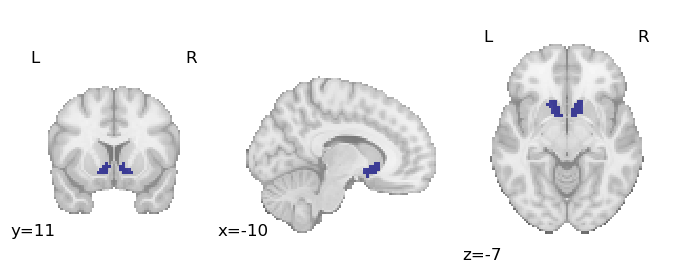

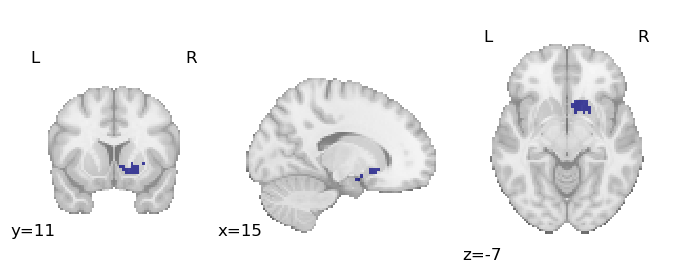

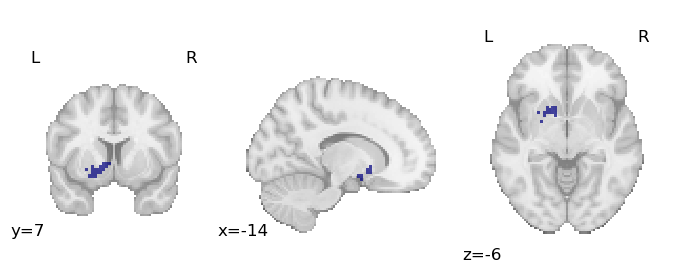

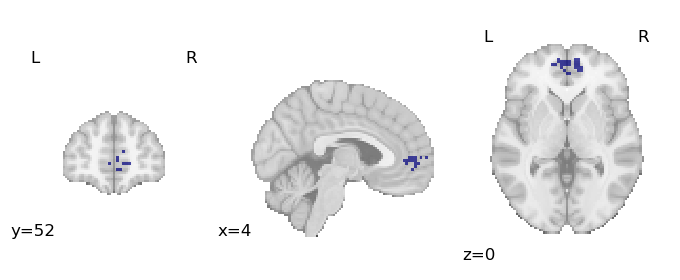

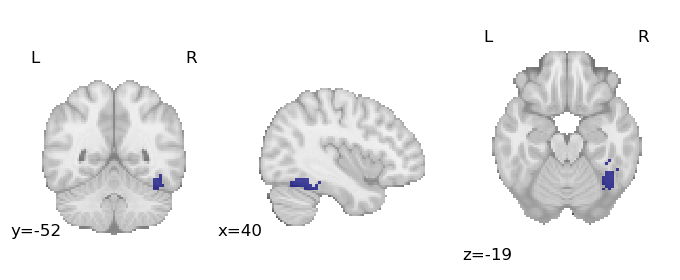

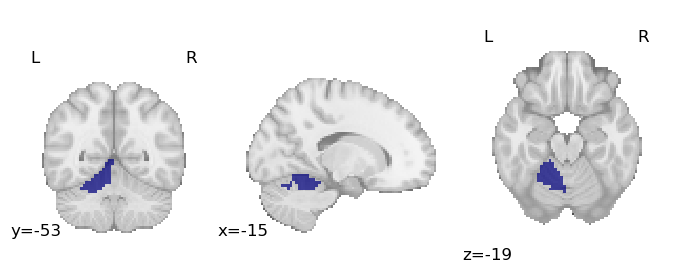

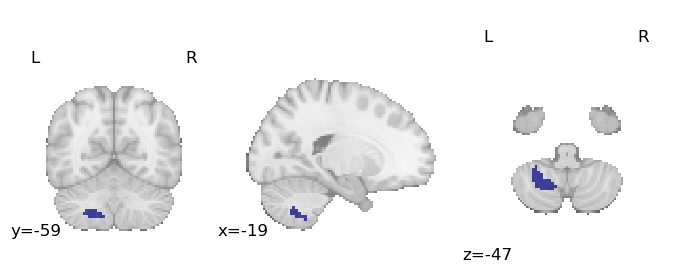

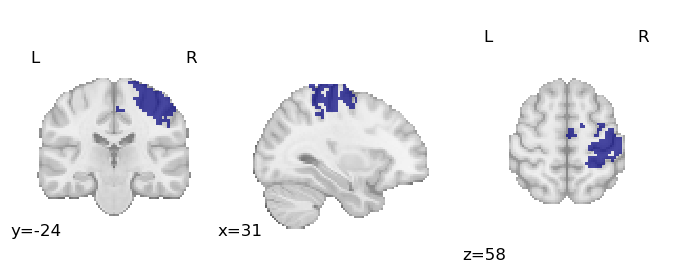

In [50]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/fROI-FFA_cname-StrVsComp_zstat-1.nii.gz'
    sCerb_mask='../masks/fROI-sCerb_cname-LeftVsRight_zstat-1.nii.gz'
    iCerb_mask='../masks/fROI-iCerb_cname-LeftVsRight_zstat-1.nii.gz'
    motor_mask='../masks/fROI-Motor_cname-LeftVsRight_zstat-1.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        plotting.plot_roi(mask,draw_cross=False)
        plt.show()

In [59]:
flist=['../derivatives/tsnr/%s_acq-%s_tsnr.nii.gz'%(row['sub'],row['acq']) for index,row in subs.iterrows()]
display(flist)
data=[]
img_list=[]
if os.path.exists("TSNRinfo.csv"):
    df=pd.read_csv("TSNRinfo.csv",sep='\t')
else:
    for img in tqdm(flist):
        start = time.time()
        tsnr_img=img
        #print(img)
        sub=re.search('tsnr/sub-(.*?)_acq',img).group(1)
        if not sub == '10136':
            me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
            mb=int(re.search('_acq-mb(.*?)me',img).group(1))
            #sub=re.search('func/sub-(.*?)_task',img).group(1)
            #print('sub: %s Multiband: %s Multiecho: %s'%(sub,mb,me))
            #tsnr_img = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=img)

            for mask in mask_list:
                nifti_masker = NiftiMasker(mask_img=mask)
                mask_name=re.search('ROI-(.*)_cname',mask).group(1)
                x=nifti_masker.fit_transform(tsnr_img)
                img=nifti_masker.inverse_transform(x)
                data.append([sub,mb,me,mask_name,np.mean(x.flatten())])
    df=pd.DataFrame(data=data,columns=['sub','MB','ME','Region','TSNR'])
    df.to_csv("TSNRinfo.tsv",sep="\t",index=False)

['../derivatives/tsnr/sub-10017_acq-mb6me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb1me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb3me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb3me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb1me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb6me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb3me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb6me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb1me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb6me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb1me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb3me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb1me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb6me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb1me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb6me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb3me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 202/202 [09:21<00:00,  2.78s/it]


In [86]:
'sub-'+df['sub']

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U4'), dtype('int64')) -> None

In [87]:
#df=pd.read_csv("TSNRinfo.csv",sep='\t')
df['acq']='mb'+df['MB'].astype(str)+'me'+df['ME'].astype(str)
#df['sub']='sub-'+df['sub'].astype(str)
display(df.head())
display(subs.head())
df2 = pd.merge(df, subs, on=["sub","acq"])
df2

,sub,MB,ME,Region,TSNR,acq
0,sub-10017,6,4,VS,31.702188,mb6me4
1,sub-10017,6,4,RVS,28.980915,mb6me4
2,sub-10017,6,4,LVS,26.821964,mb6me4
3,sub-10017,6,4,vmPFC,40.178303,mb6me4
4,sub-10017,6,4,FFA,50.127300,mb6me4


,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil
0,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64
1,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64
2,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64
4,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64


,sub,MB,ME,Region,TSNR,acq,index,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil
0,sub-10017,6,4,VS,31.702188,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
1,sub-10017,6,4,RVS,28.980915,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
2,sub-10017,6,4,LVS,26.821964,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
3,sub-10017,6,4,vmPFC,40.178303,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
4,sub-10017,6,4,FFA,50.127300,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,sub-12042,1,4,vmPFC,45.126385,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1564,sub-12042,1,4,FFA,58.243114,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1565,sub-12042,1,4,sCerb,61.147240,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1566,sub-12042,1,4,iCerb,56.616749,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20


,sub,MB,ME,Region,TSNR,acq,index,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil
0,sub-10017,6,4,VS,31.702188,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
1,sub-10017,6,4,RVS,28.980915,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
2,sub-10017,6,4,LVS,26.821964,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
3,sub-10017,6,4,vmPFC,40.178303,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
4,sub-10017,6,4,FFA,50.127300,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,sub-12042,1,4,vmPFC,45.126385,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1564,sub-12042,1,4,FFA,58.243114,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1565,sub-12042,1,4,sCerb,61.147240,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1566,sub-12042,1,4,iCerb,56.616749,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20


VS


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 196     Method:             REML     
No. Groups:       33      Scale:              17.1848  
Min. group size:  5       Log-Likelihood:     -597.6488
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   20.026    1.470  13.620 0.000 17.144 22.908
MB           0.837    0.281   2.983 0.003  0.287  1.388
ME           7.721    0.377  20.463 0.000  6.982  8.461
MB:ME       -1.378    0.096 -14.354 0.000 -1.566 -1.189
Group Var   31.036    2.240                            
=======================================================

"""

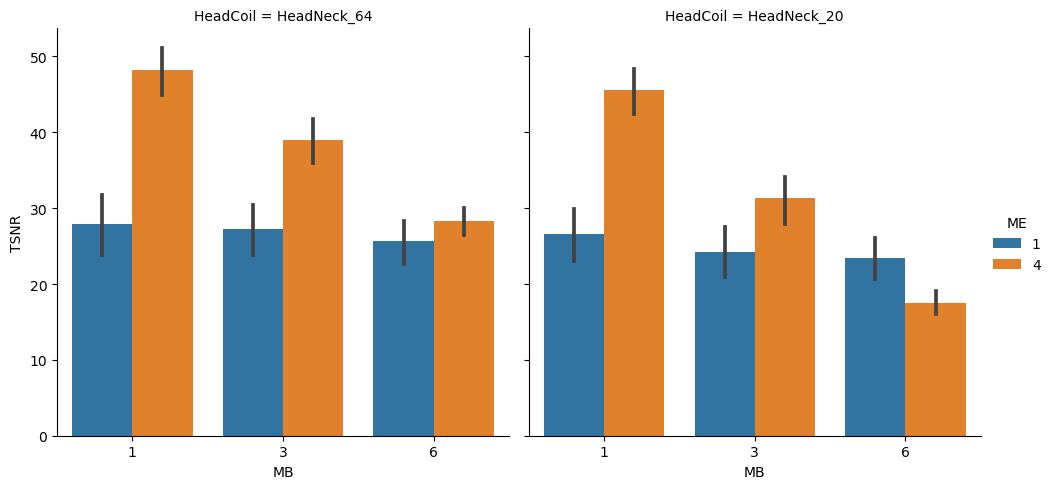

RVS


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 196     Method:             REML     
No. Groups:       33      Scale:              9.0588   
Min. group size:  5       Log-Likelihood:     -539.3145
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   28.783    1.121  25.673 0.000 26.586 30.981
MB          -0.125    0.204  -0.611 0.541 -0.524  0.275
ME           4.590    0.274  16.756 0.000  4.053  5.127
MB:ME       -0.962    0.070 -13.807 0.000 -1.099 -0.825
Group Var   20.230    1.978                            
=======================================================

"""

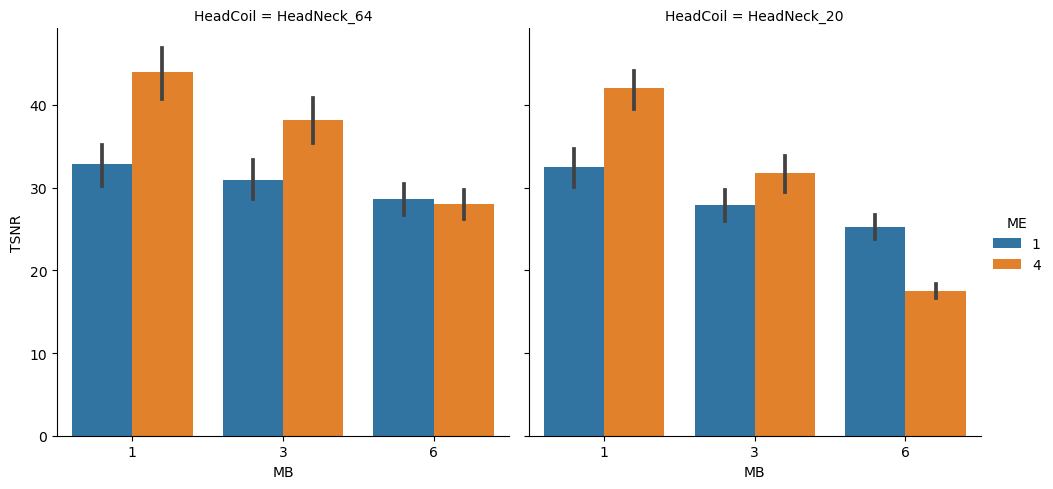

LVS


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 196     Method:             REML     
No. Groups:       33      Scale:              10.9870  
Min. group size:  5       Log-Likelihood:     -553.1113
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   23.444    1.149  20.407 0.000 21.193 25.696
MB           0.382    0.224   1.701 0.089 -0.058  0.822
ME           5.699    0.302  18.891 0.000  5.108  6.291
MB:ME       -1.106    0.077 -14.410 0.000 -1.256 -0.955
Group Var   17.784    1.621                            
=======================================================

"""

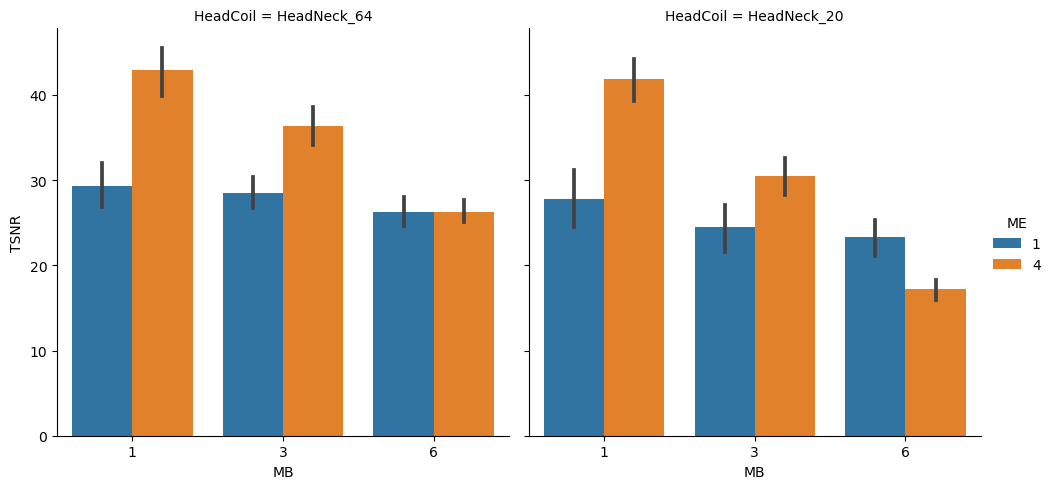

vmPFC


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 196     Method:             REML     
No. Groups:       33      Scale:              31.2712  
Min. group size:  5       Log-Likelihood:     -654.0897
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    32.211    1.954 16.486 0.000 28.381 36.040
MB           -0.304    0.379 -0.802 0.422 -1.046  0.438
ME            4.136    0.509  8.126 0.000  3.138  5.133
MB:ME        -0.457    0.129 -3.528 0.000 -0.710 -0.203
Group Var    52.620    2.838                           
=======================================================

"""

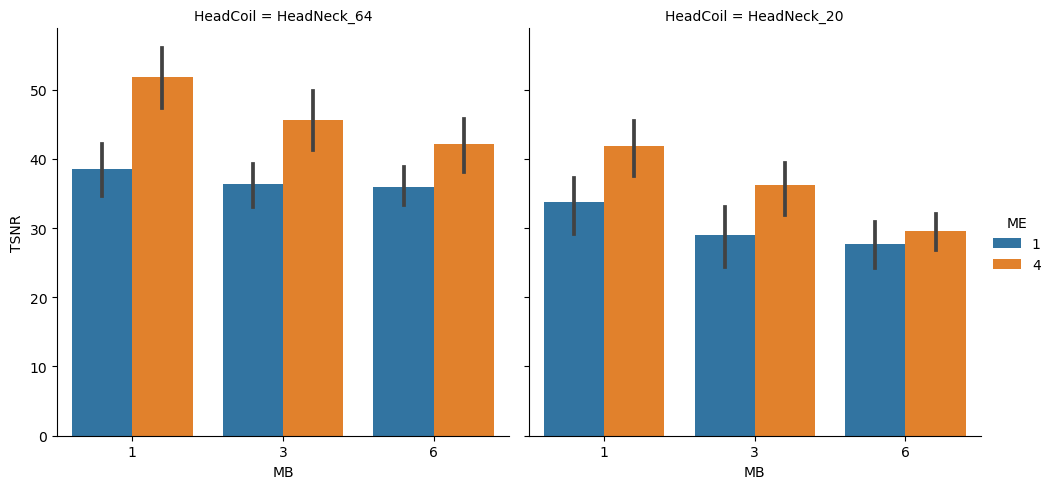

FFA


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 196     Method:             REML     
No. Groups:       33      Scale:              35.5714  
Min. group size:  5       Log-Likelihood:     -663.4445
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    35.214    2.000 17.608 0.000 31.295 39.134
MB           -0.028    0.404 -0.070 0.944 -0.820  0.763
ME            4.943    0.543  9.106 0.000  3.879  6.007
MB:ME        -0.835    0.138 -6.050 0.000 -1.106 -0.565
Group Var    48.548    2.504                           
=======================================================

"""

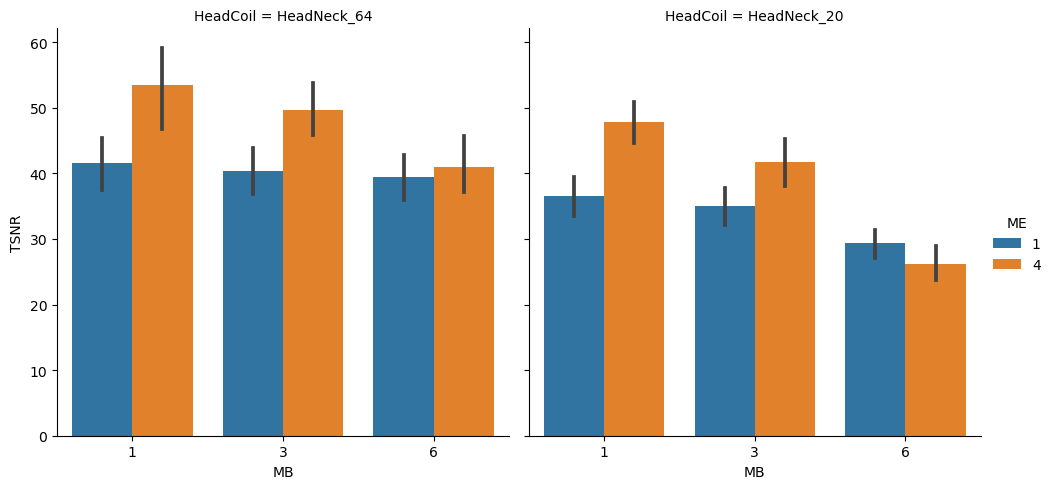

sCerb


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 196     Method:             REML     
No. Groups:       33      Scale:              14.8266  
Min. group size:  5       Log-Likelihood:     -577.0818
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   40.393    1.254  32.210 0.000 37.935 42.851
MB          -0.285    0.261  -1.094 0.274 -0.796  0.226
ME           4.718    0.350  13.464 0.000  4.031  5.405
MB:ME       -0.950    0.089 -10.660 0.000 -1.125 -0.776
Group Var   17.128    1.394                            
=======================================================

"""

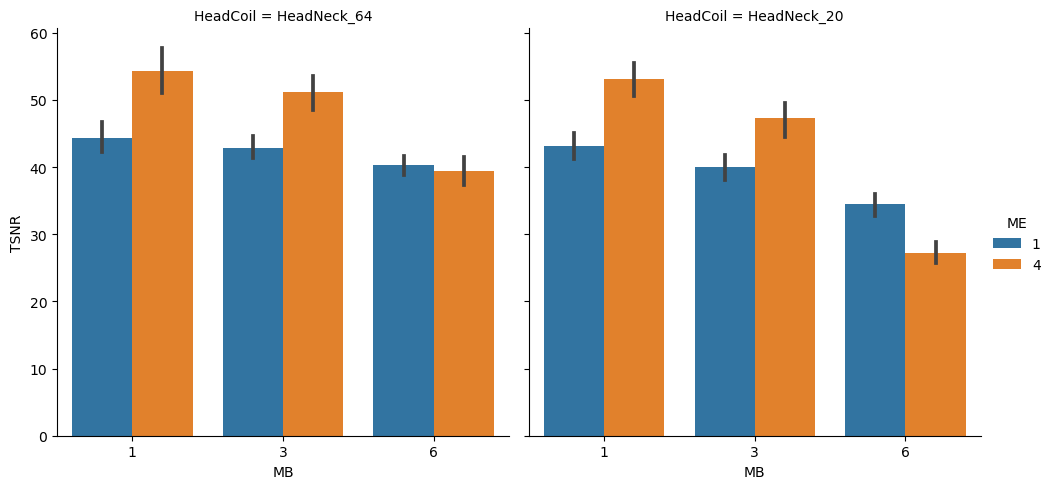

iCerb


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 196     Method:             REML     
No. Groups:       33      Scale:              26.7783  
Min. group size:  5       Log-Likelihood:     -645.6382
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    36.196    2.003 18.068 0.000 32.269 40.122
MB            0.117    0.350  0.334 0.738 -0.570  0.804
ME            4.807    0.471 10.206 0.000  3.884  5.730
MB:ME        -0.925    0.120 -7.719 0.000 -1.160 -0.690
Group Var    69.621    3.921                           
=======================================================

"""

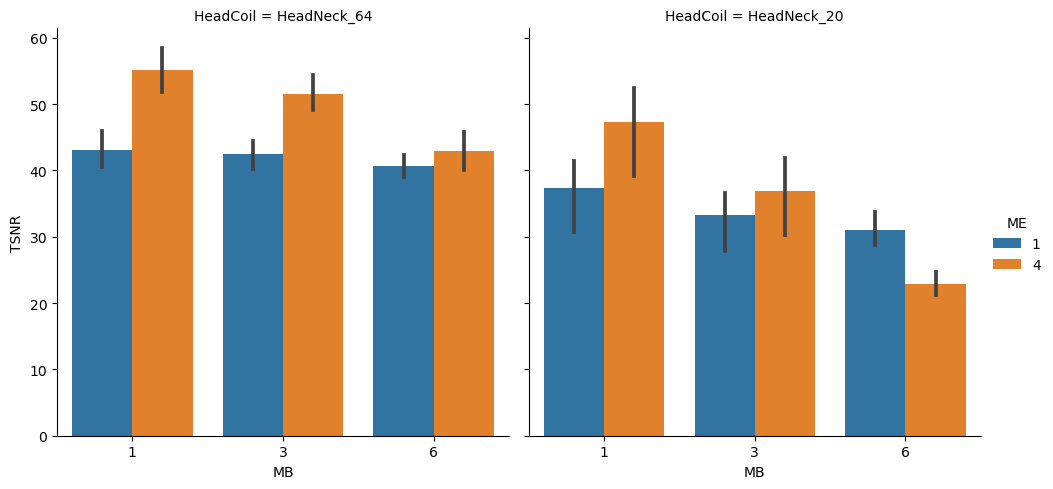

Motor


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 196     Method:             REML     
No. Groups:       33      Scale:              33.5609  
Min. group size:  5       Log-Likelihood:     -653.2065
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    44.318    1.838 24.107 0.000 40.715 47.921
MB            0.073    0.392  0.187 0.852 -0.696  0.842
ME            3.300    0.527  6.259 0.000  2.266  4.333
MB:ME        -0.805    0.134 -6.004 0.000 -1.068 -0.542
Group Var    32.818    1.819                           
=======================================================

"""

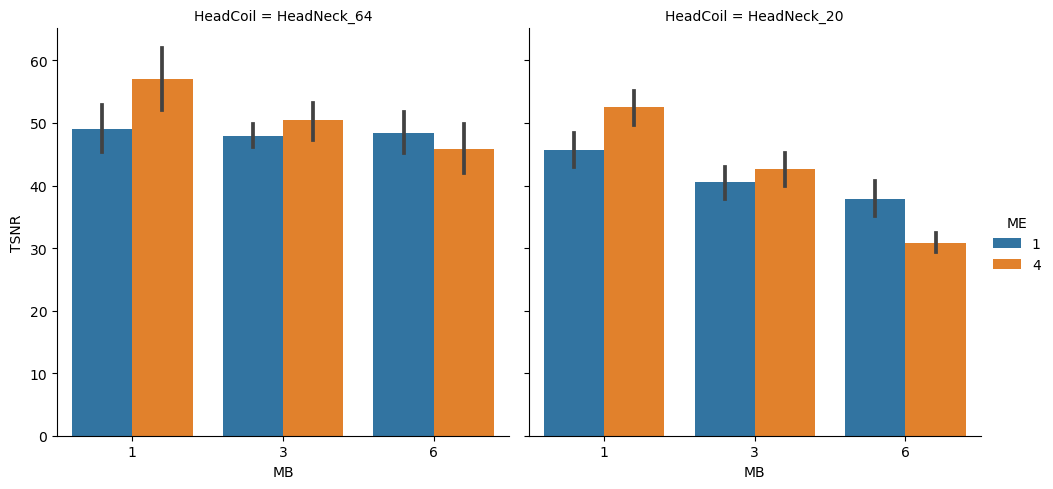

In [91]:
import matplotlib.pyplot as plt
#import statsmodels.api as sm
import statsmodels.formula.api as smf

#df=pd.read_csv("TSNRinfo.tsv",sep='\t')
display(df2)
for region in df2['Region'].unique():
    print(region)
    plt_df=df2[df2['Region']==region]
    res=smf.mixedlm('TSNR ~ MB * ME',data=plt_df,groups=plt_df['sub']).fit()
    display(res.summary())
    sns.catplot(x='MB',y='TSNR',hue='ME',col='HeadCoil',data=plt_df,kind='bar',share)
    plt.show()

In [89]:
plt_df

,sub,MB,ME,Region,TSNR,acq
0,sub-10017,6,4,VS,31.702188,mb6me4
8,sub-10017,1,4,VS,56.226482,mb1me4
16,sub-10017,3,1,VS,29.278024,mb3me1
24,sub-10017,3,4,VS,45.055321,mb3me4
32,sub-10017,1,1,VS,27.372550,mb1me1
...,...,...,...,...,...,...
1528,sub-12042,3,1,VS,30.707053,mb3me1
1536,sub-12042,6,4,VS,19.370708,mb6me4
1544,sub-12042,1,1,VS,35.245289,mb1me1
1552,sub-12042,6,1,VS,30.471955,mb6me1
